# Analysis of successful vs unsuccessful films
## In an attempt to discover what makes a film successful

## Setting up

In [0]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
metadata = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/movie_metadata.csv')
metadata.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [4]:
metadata.shape

(5043, 28)

In [5]:
metadata.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

## Data preprocessing

In [6]:
print('Number of duplicate rows:', len(metadata) - len(metadata.drop_duplicates()))

Number of duplicate rows: 45


Deleting duplicated rows:

In [0]:
metadata = metadata.drop_duplicates()

Deleting documentaries:
(because for this research we are only interested in mainstream movies)

In [8]:
metadata = metadata[~metadata['genres'].str.contains("Documentary")]
metadata.shape

(4877, 28)

In [9]:
# number of unique values in categorical columns
metadata.select_dtypes(object).apply(lambda x: len(x.unique()))

color                 3
director_name      2315
actor_2_name       2933
genres              876
actor_1_name       2007
movie_title        4796
actor_3_name       3424
plot_keywords      4657
movie_imdb_link    4798
language             48
country              63
content_rating       19
dtype: int64

What this means:

* color, language, country, and content_rating can be treated as categorical variables and encoded with numbers. Other variables should be treated as text.
* director_name and actor_X_name are still interesting because we can find directors that make cool movies (like Steven Spielberg) or actors that make movies popular (like Johnny Depp)


**Dropping irrelevant columns:**

In [10]:
columns = ['director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'cast_total_facebook_likes', 'facenumber_in_poster', 'actor_2_facebook_likes', 'movie_facebook_likes']
metadata = metadata.drop(columns, 1)
metadata.shape

(4877, 21)

In [11]:
quantitative_columns = metadata.select_dtypes([int, float]).columns
categorical_columns = ['color', 'language', 'country', 'content_rating']
numeric = metadata[quantitative_columns].copy()
numeric.head() # setting up an only numeric-data dataset

,num_critic_for_reviews,duration,gross,num_voted_users,num_user_for_reviews,budget,title_year,imdb_score,aspect_ratio
0,723.0,178.0,760505847.0,886204,3054.0,237000000.0,2009.0,7.9,1.78
1,302.0,169.0,309404152.0,471220,1238.0,300000000.0,2007.0,7.1,2.35
2,602.0,148.0,200074175.0,275868,994.0,245000000.0,2015.0,6.8,2.35
3,813.0,164.0,448130642.0,1144337,2701.0,250000000.0,2012.0,8.5,2.35
5,462.0,132.0,73058679.0,212204,738.0,263700000.0,2012.0,6.6,2.35


## Exploring the dataset

In [12]:
# encoding categorical columns with numbers
le = LabelEncoder()

for col in categorical_columns:
  column = metadata[col].apply(str)
  numeric[col] = le.fit_transform(column)
  
numeric.head()

,num_critic_for_reviews,duration,gross,num_voted_users,num_user_for_reviews,budget,title_year,imdb_score,aspect_ratio,color,language,country,content_rating
0,723.0,178.0,760505847.0,886204,3054.0,237000000.0,2009.0,7.9,1.78,1,11,60,7
1,302.0,169.0,309404152.0,471220,1238.0,300000000.0,2007.0,7.1,2.35,1,11,60,7
2,602.0,148.0,200074175.0,275868,994.0,245000000.0,2015.0,6.8,2.35,1,11,59,7
3,813.0,164.0,448130642.0,1144337,2701.0,250000000.0,2012.0,8.5,2.35,1,11,60,7
5,462.0,132.0,73058679.0,212204,738.0,263700000.0,2012.0,6.6,2.35,1,11,60,7


### Analysing correlation between columns:

In [13]:
numeric.corr()['imdb_score'].sort_values(ascending=False)

imdb_score                1.000000
num_voted_users           0.428068
num_critic_for_reviews    0.321266
num_user_for_reviews      0.306853
duration                  0.278292
gross                     0.212285
language                  0.097078
aspect_ratio              0.060018
budget                    0.033798
content_rating            0.015942
country                  -0.034273
color                    -0.147738
title_year               -0.218100
Name: imdb_score, dtype: float64

**Sorting the absolute values because there is also negative correlation:**

In [14]:
 numeric.corr()['imdb_score'].abs().sort_values(ascending=False)

imdb_score                1.000000
num_voted_users           0.428068
num_critic_for_reviews    0.321266
num_user_for_reviews      0.306853
duration                  0.278292
title_year                0.218100
gross                     0.212285
color                     0.147738
language                  0.097078
aspect_ratio              0.060018
country                   0.034273
budget                    0.033798
content_rating            0.015942
Name: imdb_score, dtype: float64

In [15]:
numeric.corr()['gross'].sort_values(ascending=False)

gross                     1.000000
num_voted_users           0.633072
num_user_for_reviews      0.558382
num_critic_for_reviews    0.474367
duration                  0.244351
imdb_score                0.212285
country                   0.153554
budget                    0.099664
aspect_ratio              0.092776
color                     0.040281
title_year                0.033293
language                 -0.102913
content_rating           -0.232946
Name: gross, dtype: float64

In [16]:
numeric.corr()['gross'].abs().sort_values(ascending=False)

gross                     1.000000
num_voted_users           0.633072
num_user_for_reviews      0.558382
num_critic_for_reviews    0.474367
duration                  0.244351
content_rating            0.232946
imdb_score                0.212285
country                   0.153554
language                  0.102913
budget                    0.099664
aspect_ratio              0.092776
color                     0.040281
title_year                0.033293
Name: gross, dtype: float64

### Visualising correlations

In [17]:
grouped = numeric[['title_year', 'imdb_score']].groupby('title_year')

scores_by_years = pd.concat([
    grouped.mean(),
    grouped.min(),
    grouped.max(),
    grouped.count()
], axis=1)

scores_by_years.columns = ['Average', 'Min', 'Max', 'Count']
scores_by_years.head()

,Average,Min,Max,Count
title_year,,,,
1916.0,8.00,8.0,8.0,1
1920.0,4.80,4.8,4.8,1
1925.0,8.30,8.3,8.3,1
1927.0,8.30,8.3,8.3,1
1929.0,7.15,6.3,8.0,2


** The range between best and worst scores over the years only increases:**

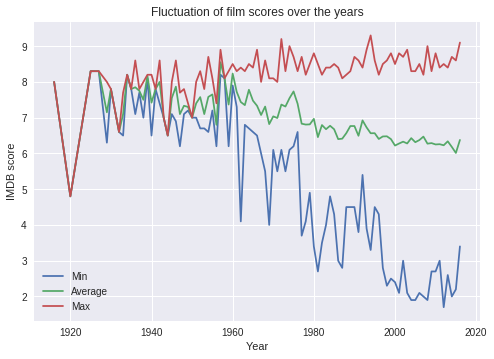

In [18]:
years = scores_by_years.index
avg_scores = scores_by_years['Average']
min_scores = scores_by_years['Min']
max_scores = scores_by_years['Max']
num_movies = scores_by_years['Count']

plt.plot(years, min_scores)
plt.plot(years, avg_scores)
plt.plot(years, max_scores)
plt.xlabel('Year')
plt.ylabel('IMDB score')
plt.title('Fluctuation of film scores over the years')
plt.legend()
plt.show()

**Which can be explained by the increasing number of movies over years:**

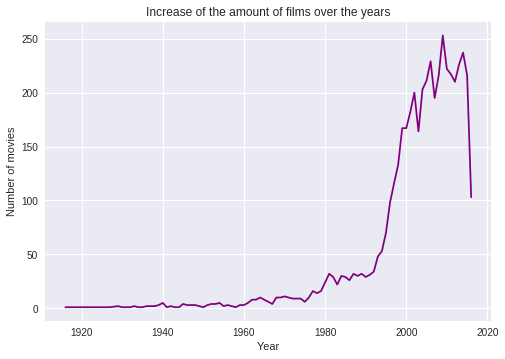

In [19]:
plt.plot(years, num_movies, color='purple')
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.title('Increase of the amount of films over the years')
plt.show()

## Determining successful/unsuccessful characteristics

In [20]:
metadata.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'actor_2_name', 'gross', 'genres', 'actor_1_name', 'movie_title',
       'num_voted_users', 'actor_3_name', 'plot_keywords', 'movie_imdb_link',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'budget', 'title_year', 'imdb_score', 'aspect_ratio'],
      dtype='object')

In [21]:
metadata['title_year'].unique()

array([2009., 2007., 2015., 2012., 2010., 2016., 2006., 2008., 2013.,
       2011., 2014., 2005., 1997., 2004., 1999., 1995., 2003., 2001.,
       2002., 1998.,   nan, 2000., 1990., 1991., 1994., 1996., 1982.,
       1993., 1979., 1992., 1989., 1984., 1988., 1978., 1962., 1980.,
       1972., 1981., 1968., 1985., 1940., 1963., 1987., 1986., 1973.,
       1983., 1976., 1977., 1970., 1971., 1969., 1960., 1965., 1964.,
       1927., 1974., 1937., 1975., 1967., 1951., 1961., 1946., 1953.,
       1954., 1959., 1932., 1947., 1956., 1945., 1952., 1930., 1966.,
       1939., 1950., 1948., 1958., 1957., 1943., 1944., 1938., 1949.,
       1936., 1941., 1955., 1942., 1929., 1935., 1933., 1916., 1934.,
       1925., 1920.])

In [22]:
# cleaning up
metadata = metadata.drop(metadata[metadata['title_year'].astype(str)=='nan'].index)
metadata.shape

(4772, 21)

**Only taking films from the last 50 years (1968-2018):**

In [23]:
metadata = metadata[metadata['title_year'].astype(int) >= 1968]
metadata.shape

(4646, 21)

**Successful films: score >= 6.4 AND gross > 30000000 AND gross > budget (actually earned money):**

In [24]:
highscore = metadata[metadata['imdb_score'].astype(float) >= 6.4]
highscore.shape
boxofficehit = highscore[highscore['gross'].astype(float) > 30000000.0]
boxofficehit.shape
successful = boxofficehit[boxofficehit['gross'].astype(float) > boxofficehit['budget'].astype(float)]
successful.shape

(948, 21)

**Unsuccessful films: score < 6.4 AND gross < budget:**

In [25]:
lowscore = metadata[metadata['imdb_score'].astype(float) < 6.4]
lowscore.shape
unsuccessful = lowscore[lowscore['gross'].astype(float) <= lowscore['budget'].astype(float)]
unsuccessful.shape

(899, 21)

In [26]:
successful.head()

,color,director_name,num_critic_for_reviews,duration,actor_2_name,gross,genres,actor_1_name,movie_title,num_voted_users,...,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,imdb_score,aspect_ratio
0,Color,James Cameron,723.0,178.0,Joel David Moore,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,...,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,7.9,1.78
1,Color,Gore Verbinski,302.0,169.0,Orlando Bloom,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,...,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,7.1,2.35
3,Color,Christopher Nolan,813.0,164.0,Christian Bale,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,...,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,8.5,2.35
8,Color,Joss Whedon,635.0,141.0,Robert Downey Jr.,458991599.0,Action|Adventure|Sci-Fi,Chris Hemsworth,Avengers: Age of Ultron,462669,...,artificial intelligence|based on comic book|ca...,http://www.imdb.com/title/tt2395427/?ref_=fn_t...,1117.0,English,USA,PG-13,250000000.0,2015.0,7.5,2.35
9,Color,David Yates,375.0,153.0,Daniel Radcliffe,301956980.0,Adventure|Family|Fantasy|Mystery,Alan Rickman,Harry Potter and the Half-Blood Prince,321795,...,blood|book|love|potion|professor,http://www.imdb.com/title/tt0417741/?ref_=fn_t...,973.0,English,UK,PG,250000000.0,2009.0,7.5,2.35


In [27]:
unsuccessful.head()

,color,director_name,num_critic_for_reviews,duration,actor_2_name,gross,genres,actor_1_name,movie_title,num_voted_users,...,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,imdb_score,aspect_ratio
11,Color,Bryan Singer,434.0,169.0,Marlon Brando,200069408.0,Action|Adventure|Sci-Fi,Kevin Spacey,Superman Returns,240396,...,crystal|epic|lex luthor|lois lane|return to earth,http://www.imdb.com/title/tt0348150/?ref_=fn_t...,2367.0,English,USA,PG-13,209000000.0,2006.0,6.1,2.35
24,Color,Chris Weitz,251.0,113.0,Eva Green,70083519.0,Adventure|Family|Fantasy,Christopher Lee,The Golden Compass,149019,...,children|epic|friend|girl|quest,http://www.imdb.com/title/tt0385752/?ref_=fn_t...,666.0,English,USA,PG-13,180000000.0,2007.0,6.1,2.35
28,Color,Peter Berg,377.0,131.0,Alexander Skarsgård,65173160.0,Action|Adventure|Sci-Fi|Thriller,Liam Neeson,Battleship,202382,...,box office flop|hawaii|naval|oahu hawaii|ship,http://www.imdb.com/title/tt1440129/?ref_=fn_t...,751.0,English,USA,PG-13,209000000.0,2012.0,5.9,2.35
41,Color,John Lasseter,304.0,106.0,Thomas Kretschmann,191450875.0,Adventure|Animation|Comedy|Family|Sport,Joe Mantegna,Cars 2,101178,...,best friend|car race|conspiracy|gadget car|spy,http://www.imdb.com/title/tt1216475/?ref_=fn_t...,283.0,English,USA,G,200000000.0,2011.0,6.3,2.35
42,Color,Martin Campbell,436.0,123.0,Temuera Morrison,116593191.0,Action|Adventure|Sci-Fi,Ryan Reynolds,Green Lantern,223393,...,autopsy|lantern|planet|ring|test pilot,http://www.imdb.com/title/tt1133985/?ref_=fn_t...,550.0,English,USA,PG-13,200000000.0,2011.0,5.6,2.35


## Fixing up the newly formed datasets

**Separating genres into actual columns:**

In [28]:
successful = successful.join(successful.pop('genres').str.get_dummies('|'))
successful.head()

,color,director_name,num_critic_for_reviews,duration,actor_2_name,gross,actor_1_name,movie_title,num_voted_users,actor_3_name,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,Color,James Cameron,723.0,178.0,Joel David Moore,760505847.0,CCH Pounder,Avatar,886204,Wes Studi,...,0,0,0,0,0,1,0,0,0,0
1,Color,Gore Verbinski,302.0,169.0,Orlando Bloom,309404152.0,Johnny Depp,Pirates of the Caribbean: At World's End,471220,Jack Davenport,...,0,0,0,0,0,0,0,0,0,0
3,Color,Christopher Nolan,813.0,164.0,Christian Bale,448130642.0,Tom Hardy,The Dark Knight Rises,1144337,Joseph Gordon-Levitt,...,0,0,0,0,0,0,0,1,0,0
8,Color,Joss Whedon,635.0,141.0,Robert Downey Jr.,458991599.0,Chris Hemsworth,Avengers: Age of Ultron,462669,Scarlett Johansson,...,0,0,0,0,0,1,0,0,0,0
9,Color,David Yates,375.0,153.0,Daniel Radcliffe,301956980.0,Alan Rickman,Harry Potter and the Half-Blood Prince,321795,Rupert Grint,...,0,0,0,1,0,0,0,0,0,0


In [29]:
unsuccessful = unsuccessful.join(unsuccessful.pop('genres').str.get_dummies('|'))
unsuccessful.head()

,color,director_name,num_critic_for_reviews,duration,actor_2_name,gross,actor_1_name,movie_title,num_voted_users,actor_3_name,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
11,Color,Bryan Singer,434.0,169.0,Marlon Brando,200069408.0,Kevin Spacey,Superman Returns,240396,Frank Langella,...,0,0,0,0,0,1,0,0,0,0
24,Color,Chris Weitz,251.0,113.0,Eva Green,70083519.0,Christopher Lee,The Golden Compass,149019,Kristin Scott Thomas,...,0,0,0,0,0,0,0,0,0,0
28,Color,Peter Berg,377.0,131.0,Alexander Skarsgård,65173160.0,Liam Neeson,Battleship,202382,Tadanobu Asano,...,0,0,0,0,0,1,0,1,0,0
41,Color,John Lasseter,304.0,106.0,Thomas Kretschmann,191450875.0,Joe Mantegna,Cars 2,101178,Eddie Izzard,...,0,0,0,0,0,0,1,0,0,0
42,Color,Martin Campbell,436.0,123.0,Temuera Morrison,116593191.0,Ryan Reynolds,Green Lantern,223393,Taika Waititi,...,0,0,0,0,0,1,0,0,0,0


In [30]:
successful.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'actor_2_name', 'gross', 'actor_1_name', 'movie_title',
       'num_voted_users', 'actor_3_name', 'plot_keywords', 'movie_imdb_link',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'budget', 'title_year', 'imdb_score', 'aspect_ratio', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

**Making datasets only made of genres data, for futher analysis:**

In [31]:
ncol = len(successful.columns)
s_genres = successful[successful.columns[20:ncol]]
s_genres.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

In [32]:
ncol = len(unsuccessful.columns)
u_genres = unsuccessful[unsuccessful.columns[20:ncol]]
u_genres.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

In [33]:
successful.budget.unique().min()

60000.0

In [34]:
successful.budget.unique().max()

300000000.0

In [35]:
unsuccessful.budget.unique().min()

60000.0

In [36]:
unsuccessful.budget.unique().max()

1000000000.0

## Exploring the data through visualisations

### Comparing budgets of successful vs unsuccessful films:

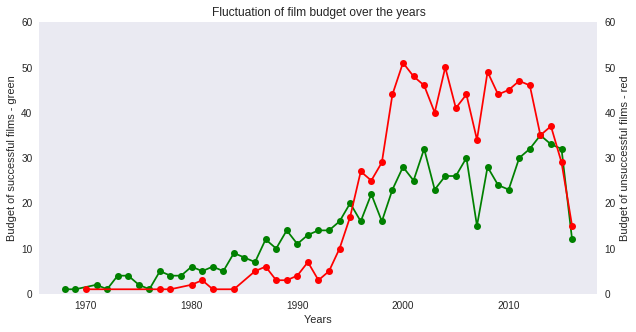

In [37]:
bdgt_analysis_s = successful[['budget', 'title_year']].groupby('title_year')
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(bdgt_analysis_s.title_year.first(), bdgt_analysis_s.budget.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,60)

bdgt_analysis_u = unsuccessful[['budget', 'title_year']].groupby('title_year')
ax2 = ax1.twinx()
ax2.plot(bdgt_analysis_u.title_year.first(), bdgt_analysis_u.budget.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,60)


# green - successful, red - unsuccessful

ax1.set_xlabel('Years')
ax1.set_ylabel('Budget of successful films - green'); ax2.set_ylabel('Budget of unsuccessful films - red')
plt.title('Fluctuation of film budget over the years')
plt.show()

### Exploring duration/score, gross/score and duration/gross

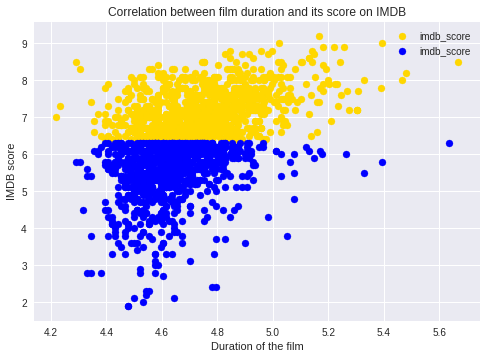

In [38]:
plt.scatter(
    np.log(successful['duration']),
    successful['imdb_score'],
    color='gold')
plt.scatter(
    np.log(unsuccessful['duration']),
    unsuccessful['imdb_score'],
    color='blue')

plt.xlabel('Duration of the film')
plt.ylabel('IMDB score')
plt.title('Correlation between film duration and its score on IMDB')
plt.legend()

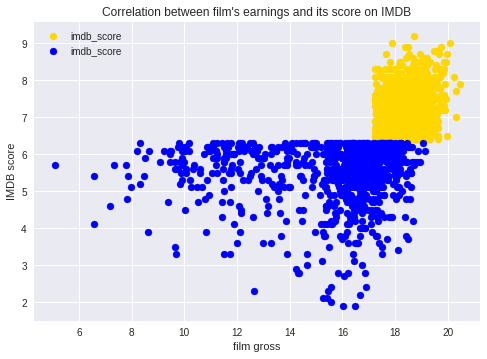

In [39]:
plt.scatter(
    np.log(successful['gross']),
    successful['imdb_score'],
    color='gold')
plt.scatter(
    np.log(unsuccessful['gross']),
    unsuccessful['imdb_score'],
    color='blue')

plt.xlabel('film gross')
plt.ylabel('IMDB score')
plt.title("Correlation between film's earnings and its score on IMDB")
plt.legend()

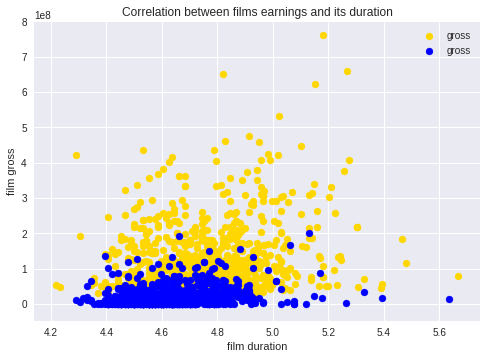

In [40]:
plt.scatter(
    np.log(successful['duration']),
    successful['gross'],
    color='gold')
plt.scatter(
    np.log(unsuccessful['duration']),
    unsuccessful['gross'],
    color='blue')

plt.xlabel('film duration')
plt.ylabel('film gross')
plt.title('Correlation between films earnings and their duration')
plt.legend()

### Exploring genres data points

In [41]:
indiv_genres = list(s_genres.columns.values)
s_genr_numb = []
for genre in indiv_genres:
  s_genr_numb.append(s_genres[genre].astype(bool).sum(axis=0))
s_dictionary = dict(zip(indiv_genres, s_genr_numb))
s_sort_dict = sorted(s_dictionary.items() , key=lambda t : t[1] , reverse=True)
for k,v in s_sort_dict:
  print(k,v)

Drama 485
Comedy 321
Thriller 292
Action 266
Adventure 257
Romance 194
Crime 174
Fantasy 150
Sci-Fi 144
Family 142
Mystery 102
Animation 78
Biography 76
Horror 64
Sport 45
History 36
War 36
Music 34
Musical 25
Western 18


In [42]:
u_genr_numb = []
for genre in indiv_genres:
  u_genr_numb.append(u_genres[genre].astype(bool).sum(axis=0))
u_dictionary = dict(zip(indiv_genres, u_genr_numb))
u_sort_dict = sorted(u_dictionary.items() , key=lambda t : t[1] , reverse=True)
for k,v in u_sort_dict:
  print(k,v)

Comedy 407
Drama 351
Action 319
Thriller 314
Adventure 200
Romance 196
Crime 183
Sci-Fi 160
Fantasy 152
Family 110
Horror 100
Mystery 87
Animation 34
War 30
Music 29
Sport 29
Musical 25
Biography 19
History 19
Western 16


**Based on the number of films:**

Text(0.5,1,'Number of films in respective film genres')

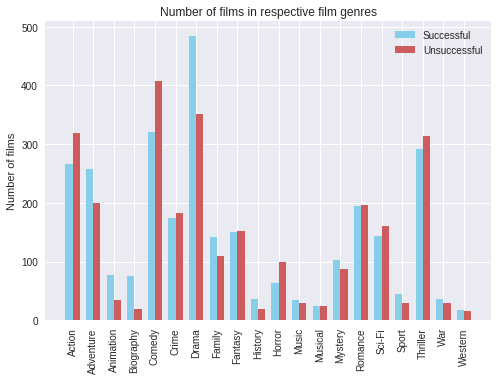

In [43]:
s_means = s_dictionary.values()
u_means = u_dictionary.values()

ind = np.arange(len(s_means))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, s_means, width, color='SkyBlue', label='Successful')
rects2 = ax.bar(ind + width/2, u_means, width, color='IndianRed', label='Unsuccessful')

ax.set_ylabel('Number of films')
ax.set_title('Successful v unsuccessful')
ax.set_xticks(ind)
ax.set_xticklabels(s_dictionary.keys(), rotation='vertical')
ax.legend()
plt.title('Number of films in respective film genres')

**Based on percentage of certain genres in successful vs unsuccessful films:**

In [0]:
def percentage(part, whole):
  return 100 * float(part)/float(whole)

In [0]:
s_percent = []
u_percent = []
for i in range(len(s_genr_numb)):
  sum = s_genr_numb[i] + u_genr_numb[i]
  s_percent.append(percentage(s_genr_numb[i], sum))
  u_percent.append(percentage(u_genr_numb[i], sum))

Text(0.5,1,'Percentage of films in respective film genres')

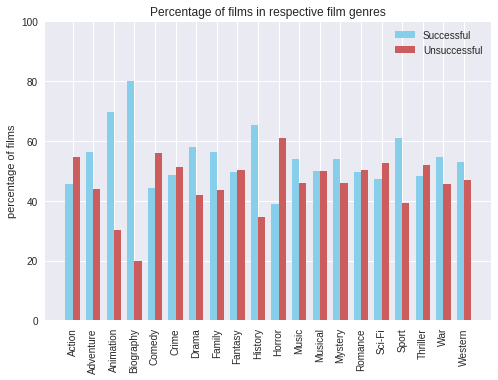

In [46]:
ind = np.arange(len(s_percent))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, s_percent, width, color='SkyBlue', label='Successful')
rects2 = ax.bar(ind + width/2, u_percent, width, color='IndianRed', label='Unsuccessful')

ax.set_ylabel('percentage of films')
ax.set_title('successful v unsuccessful')
ax.set_xticks(ind)
ax.set_xticklabels(s_dictionary.keys(), rotation='vertical')
ax.set_ylim(0,100)
ax.legend()
plt.title('Percentage of films in respective film genres')

## Analysing movie director data

In [47]:
# which director has the most films
metadata.groupby('director_name')['movie_title'].count().sort_values(ascending=False).head()

director_name
Steven Spielberg    26
Woody Allen         22
Clint Eastwood      20
Martin Scorsese     18
Ridley Scott        17
Name: movie_title, dtype: int64

In [48]:
# which director has the most films that are SUCCESSFUL according to this research
successful.groupby('director_name')['movie_title'].count().sort_values(ascending=False).head()

director_name
Steven Spielberg     20
Clint Eastwood       11
Peter Jackson         9
Steven Soderbergh     9
Robert Zemeckis       9
Name: movie_title, dtype: int64

In [49]:
# directors based on their average IMDB scores for all movies
metadata.groupby('director_name')['imdb_score'].mean().sort_values(ascending=False).head()

director_name
Sadyk Sher-Niyaz    8.7
Mitchell Altieri    8.7
Mike Mayhall        8.6
Raja Menon          8.5
Damien Chazelle     8.5
Name: imdb_score, dtype: float64

In [50]:
# directors based on their average IMDB scores for successful movies
successful.groupby('director_name')['imdb_score'].mean().sort_values(ascending=False).head()

director_name
Irvin Kershner       8.800000
Frank Darabont       8.500000
Roger Allers         8.500000
Milos Forman         8.500000
Christopher Nolan    8.414286
Name: imdb_score, dtype: float64

In [51]:
# directors based on their maximum IMDB scores for all movies
metadata.groupby('director_name')['imdb_score'].max().sort_values(ascending=False).head()

director_name
Frank Darabont          9.3
Francis Ford Coppola    9.2
John Stockwell          9.1
Christopher Nolan       9.0
Peter Jackson           8.9
Name: imdb_score, dtype: float64

In [52]:
# directors based on their maximum IMDB scores for successful movies
successful.groupby('director_name')['imdb_score'].max().sort_values(ascending=False).head(5)

director_name
Francis Ford Coppola    9.2
Christopher Nolan       9.0
Steven Spielberg        8.9
Quentin Tarantino       8.9
Peter Jackson           8.9
Name: imdb_score, dtype: float64

## Analysing years with the most number of successful/unsuccessful films

In [53]:
successful.groupby('title_year')['movie_title'].count().sort_values(ascending=False).head()

title_year
2013.0    54
2014.0    48
2015.0    45
2012.0    45
2011.0    42
Name: movie_title, dtype: int64

In [54]:
unsuccessful.groupby('title_year')['movie_title'].count().sort_values(ascending=False).head()

title_year
2000.0    51
2004.0    50
2008.0    49
2001.0    48
2011.0    47
Name: movie_title, dtype: int64